In [5]:
import numpy as np

class chessboard(object):
    def __init__(self,n_states = [8,8],init_state=np.array((0,0))):
        """Q-learning: Knights tour task. Make the knight visit as many positions on the 
                    chessboard as possible without visiting any state twice

        Args:
        state (int): x & y size of the chessboard
        init_state (int): x,y position at which the knight starts his tour
        """
        
        self.name = "chess_board"
        self.n_actions = 8                   # number of possible of a night
        self.dim_x = n_states[0]             # dimensionality x
        self.dim_y = n_states[0]             # dimensionality x
        self.visited_states = [init_state]   # list of visited states

    def step(self,action):
        new_state = self.visited_states[-1] + action
        
        if any((new_state == x).all() for x in self.visited_states):
            # negative reward & terminate game by appending False in list of visited states 
            # if new state has been visited before
            reward = -100
            self.visited_states.append(False)
        else:
            # positive reward if state has not been visited before
            reward = 10
            self.visited_states.append(new_state)
                   
        return reward
        
    def translate_action(self,action):
        # translate action index into change in x,y
        action_step = [np.array((-1,-2)),np.array((1,-2)),np.array((1,2)),np.array((-1,2)),np.array((-2,-1)), np.array((2,-1)),np.array((2,1)),np.array((-2,1))]

        return action_step[action]
                
    def epsilon_greedy(self,q, epsilon):
       
        # exclude impossible actions:
        # test all 8 actions on current state &  give index of actions that end up on chessboard
        
        future_states = self.visited_states[-1] + self.translate_action(slice(0,8))
        xx = np.logical_and(future_states>=0,future_states<8)
        possible_actions = [ind for ind,x in enumerate(xx) if np.all(x==True)]
    
    
        if np.random.random() > epsilon:
            # exploratory behavioir: chose random action from all possible actions
            v = q[possible_actions]
            action = np.random.choice(np.flatnonzero(v == v.max()))           
            action = possible_actions[action]
        else:
            # chose best action from all possible actions
            action = np.random.choice(possible_actions)
        
        return action    

    def learning_rule(self,action,reward,value,params):
        q = value[self.visited_states[-2][0],self.visited_states[-2][1], action]

        if self.visited_states[-1] is False:
            max_next_q = -100
        else:
            # only include possible actions:
            next_states = self.visited_states[-1] + self.translate_action(slice(0,8))
            xx = np.logical_and(next_states>=0,next_states<8)
            possible_actions = [ind for ind,x in enumerate(xx) if np.all(x==True)]
                
            max_next_q = np.max(value[self.visited_states[-1][0],self.visited_states[-1][1],possible_actions])

        # temporal difference error
        td_error = reward + params['gamma'] * max_next_q - q
        # update Q-value for the state-action pair
        value[self.visited_states[-2][0],self.visited_states[-2][1], action] = q + params['alpha'] * td_error

        return value

        
    def learn(self,params, max_steps, n_episodes,init_state=np.array((3,6))):
        #q-table
        value = np.zeros((self.dim_x,self.dim_y,self.n_actions))

        #initilize reward for each episode
        reward_sums = np.zeros(n_episodes)
        # initialize number of visited states in each episode
        NumPlacesVisited = np.zeros(n_episodes)
        
        epsilon_use = params['epsilon']
        depsilon = params['epsilon']/(n_episodes-20)

        # save paths of 10 last games for visualization
        SaveEps = np.linspace(2000-10,2000,10)
        SaveEps = SaveEps.astype(int)
        visited_states = [None] * len(SaveEps)
        n = 0

        for episode in range(n_episodes):   
            reward_sum = 0
            self.visited_states = [init_state]

            for t in range(max_steps):

                # chose action
                action = self.epsilon_greedy(value[self.visited_states[-1][0],self.visited_states[-1][1]],epsilon_use)
                
                # translate action index into x,y change
                action_step = self.translate_action(action)
                
                #make step
                reward = self.step(action_step)

                # update value function
                value = self.learning_rule(action,reward,value,params)
                               
                reward_sum +=reward
            
                if self.visited_states[-1] is False:
                    break
                    
            reward_sums[episode] = reward_sum
            visited = [list(x) for x in set(tuple(x) for x in self.visited_states[:-2])]
            NumPlacesVisited[episode] = len(visited)
            epsilon_use -=depsilon
            
            if episode in SaveEps:
                visited_states[n] = self.visited_states
                n += 1
                
        return reward_sums, NumPlacesVisited,visited_states
 

In [6]:
import matplotlib.pyplot as plt
import imageio
import os

np.random.seed(2)

params = {
  'epsilon': 0.1,  # epsilon-greedy policy
  'alpha': 0.3,  # learning rate   
  'gamma': 1,  # discount factor
}

# episodes/trials
n_episodes = 6000
max_steps = 100

# environment initialization
Chess = chessboard()

reward_sums,NumPlacesVisited,visited_states = Chess.learn(params, max_steps, n_episodes)

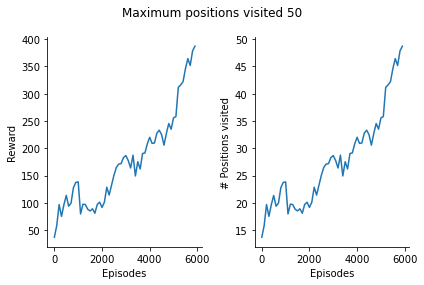

In [9]:
# Plot Improvement of reward/visited states across episodes

Folder = 'C:/Users/schneiderm/Desktop/Imbizo2022/MiniProject_KnightsTour/'
Episodes = np.arange(0,len(NumPlacesVisited),100)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Maximum positions visited '+str(int(np.max(NumPlacesVisited))))
ax1.plot(Episodes,np.mean(reward_sums.reshape(-1, 100), axis=1))
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Reward")
ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)


ax2.plot(Episodes,np.mean(NumPlacesVisited.reshape(-1, 100), axis=1))
ax2.set_xlabel("Episodes")
ax2.set_ylabel("# Positions visited")
ax2.spines.right.set_visible(False)
ax2.spines.top.set_visible(False)
plt.tight_layout()
plt.savefig(Folder+"Figure1.jpg")


In [10]:
# make gif of knights tour

board = np.zeros((8,8))
for i in range(board.shape[0]):
    if (i % 2) == 0:
        board[i,0::2] = 1
    else:
        board[i,1::2] = 1


for num in range(len(visited_states)):
    filenamesDel = []
    plt.imshow(board, cmap='gray')    
    for i in range(len(visited_states[num])-1):
        plt.plot(visited_states[num][i][0],visited_states[num][i][1],marker = "o",color='r')
        
        # create file name and append it to a list
        filename = str(i)+'.jpg'
        filenamesDel.append(filename)

        # save frame
        plt.savefig(filename)
    plt.close()    

    frames = []    
    filenameGIF = 'Game'+str(num)+'.gif'
    for filename in filenamesDel:
        frames.append(imageio.imread(Folder + filename))

    # Save them as frames into a gif 
    kargs = { 'duration': 1 }
    imageio.mimsave(filenameGIF, frames, 'GIF', **kargs)
        
    # Remove files
    for filename in set(filenamesDel):
        os.remove(filename)